In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
#normalized p-y curves
# y_norm=np.arange(0,10.1,0.1)
# p_norm=np.zeros_like(y_norm)
# for i,j in enumerate(y_norm): #ask
#     if y_norm[i] <= 8:
#         p_norm[i]=0.5*y_norm[i]**(1/3)
#     else:
#         p_norm[i]=0.5*8**(1/3) #P/P_ult
# fnp=interp1d(y_norm,p_norm,kind='linear') #function to read P/P_ult
#undrained shear strength profile
d=np.arange(0,101,1) #divide pile length to 1 feet segment and 101 nodes
s_u=100+10*d #calculate distribution of shear strength
#calculate P_ult profile
rho_soil_b=62.6 #effective unit weight (125-62.4) in psf
d_m=3 #diameter of the pile
n_p=3+(rho_soil_b*d/s_u)+(0.5*d/d_m) #calculate distribution of N_p
n_p=np.where(n_p>9,9,n_p) #replacing Np>9 with 9
p_ult=n_p*s_u*d_m #calculate distribution of P_ult in lb
p_ult=p_ult.reshape(len(p_ult),1)
#calculate y50 based on shear strength profile
e50=[] #initialize empty array of e50
s_u_si=s_u*0.04788025888888984 #convert shear strength profile psf to kN/m2
#assigning e50 values depending on the shear strength (refer to table used)
for i,j in enumerate(s_u_si):
    if s_u_si[i]<=24:
        e50.append(0.02)
    elif s_u_si[i]>24 and s_u_si[i]<48:
        e50.append(0.01)
    else:
        e50.append(0.006)
e50=np.array(e50) #turn to array
y50=e50*2.5*d_m #calculate y50 in feet
#define acceptale tolerance
tol=0.001*d_m #tolerance assigned of 0.1% of diameter
k=np.array([0.0]*(len(d)**2)).reshape(len(d),len(d)) #initialize empty k stiffness
#imposing BC Floating Pile and create stiffness matrix 
k[0,0]=1
k[1,0],k[1,1],k[1,2]=1,-2,1
k[len(k)-1,len(k)-1],k[len(k)-1,len(k)-2],k[len(k)-1,len(k)-3]=1,-2,1
k[len(k)-2,len(k)-1],k[len(k)-2,len(k)-2],k[len(k)-2,len(k)-3],k[len(k)-2,len(k)-4]=1,-3,3,-1
for i,j in enumerate(k[2:len(k)-2]):
    k[i+2,i]=1
    k[i+2,i+1]=-4
    k[i+2,i+3]=-4
    k[i+2,i+4]=1
#define initial trial for displacement profile
y0=2/12 #top displacement at 2 inch (converted to feet)
# y=y0-(y0/max(d))*d #distribution of displacement along the pile
# y[len(y)-1]=0.001 #assign 0.001 ft displacement at the tip
# y_rat=y/y50 #ratio of y/y50 for calculation purposes
temp_y=y0-(y0/max(d))*d #distribution of displacement along the pile
temp_y[len(temp_y)-1]=0.001 #assign 0.001 ft displacement at the tip
temp_y=temp_y.reshape(len(temp_y),1)
delta_x=1#distance between nodes (ft) (consistent here)
inertia_m=(math.pi/64)*((3**4)-(2.75**4)) #calculate I in ft^4
e_mod=4176000000 #in psf
load_v=np.array([0.0]*(len(d))).reshape(len(d),1) #initialize empty k stiffness
load_v[0]=np.float64(y0) #assigning boundary condition to the load vector
#calculate new p
# p_n=p_ult*0.5*(y_rat)**(1/3) #compute p along the depth of the pile using y trial
# k_s=p_n/abs(y) #compute stiffness per nodes based on p_n and y in lb/ft
# #p=fnp(y_rat)*p_ult
# #reiterate diagonal (put to iterative loop)
# for i,j in enumerate(k[2:len(k)-2]):
#     k[i+2,i+2]=6+(k_s[i+2]*(delta_x**4))/(inertia_m*e_mod)
# temp_y=np.linalg.solve(k,load_v)
# diff=np.asarray(abs(temp_y-(y.reshape(len(y),1))))
# p_ult=p_ult.reshape(len(p_ult),1)
## Main Iterative Loop ##
counter=0
while counter<50:
    counter+=1
    y_ratn=temp_y/y50.reshape(len(y50),1)
    y_ratn=y_ratn.reshape(len(y_ratn),1)
    p_n=p_ult*0.5*(abs(y_ratn))**(1/3)
    k_s=p_n/abs(temp_y)
    for i,j in enumerate(k[2:len(k)-2]):
        k[i+2,i+2]=6+(k_s[i+2]*(delta_x**4))/(inertia_m*e_mod)
    new_y=np.linalg.solve(k,load_v)
    diff=np.asarray(abs(new_y-temp_y))
    if max(diff)>tol:
        temp_y=new_y
    elif max(diff)<=tol:
        break
        
# new_y
counter

3

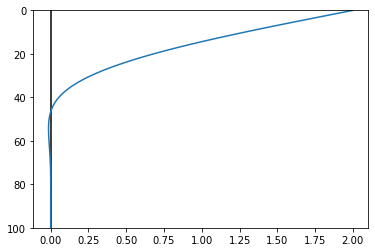

In [21]:
plt.ylim(max(d),0)
# plt.xlim(-0.5,0.5)
x=[0]*len(d)
plt.plot(x,d,'k')
plt.plot(new_y*12,d)


In [22]:
new_y

array([[ 1.66666667e-01],
       [ 1.60573519e-01],
       [ 1.54480372e-01],
       [ 1.48398875e-01],
       [ 1.42340514e-01],
       [ 1.36316580e-01],
       [ 1.30338135e-01],
       [ 1.24415973e-01],
       [ 1.18560596e-01],
       [ 1.12782173e-01],
       [ 1.07090515e-01],
       [ 1.01495034e-01],
       [ 9.60047221e-02],
       [ 9.06281117e-02],
       [ 8.53732518e-02],
       [ 8.02476762e-02],
       [ 7.52583766e-02],
       [ 7.04117910e-02],
       [ 6.57137948e-02],
       [ 6.11696927e-02],
       [ 5.67842126e-02],
       [ 5.25614999e-02],
       [ 4.85051136e-02],
       [ 4.46180233e-02],
       [ 4.09026082e-02],
       [ 3.73606565e-02],
       [ 3.39933670e-02],
       [ 3.08013517e-02],
       [ 2.77846395e-02],
       [ 2.49426820e-02],
       [ 2.22743601e-02],
       [ 1.97779924e-02],
       [ 1.74513448e-02],
       [ 1.52916420e-02],
       [ 1.32955800e-02],
       [ 1.14593407e-02],
       [ 9.77860743e-03],
       [ 8.24858290e-03],
       [ 6.8